In [ ]:
# Importing the necessary library

import nltk
import matplotlib.pyplot as plt
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from string import punctuation
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data = pd.read_csv('/kaggle/input/dataisbeautiful/r_dataisbeautiful_posts.csv')

In [ ]:
data.head()

In [ ]:
# Checking for if there is any null values
data.isnull().sum()

* We can see that the columns 'author_flair_text', 'removed_by', 'totla_award_recieved' and 'awrders' have lots of missing values so it would be better to drop them

In [ ]:
data.drop(['author_flair_text', 'removed_by', 'total_awards_received', 'awarders'],axis = 1, inplace = True)

Also deleting the some other columns which are not making sense, columns like 'id', 'created_utc', 'full_link'

In [ ]:
data.drop(['id', 'created_utc', 'full_link'], axis=1, inplace=True)

In [ ]:
data.head()

We have already seen that there is one missing value in the column title

In [ ]:
# filling the missing value in the column 'title'
data['title'].fillna(" ", inplace=True)

In [ ]:
# Finally checking if there is any null values
data.isnull().sum()

There is no null values in the data so we can move ahead

In [ ]:
data['text'] = data['title'] + ' ' + data['author']
data.drop(['title', 'author'], axis = 1, inplace = True)

In [ ]:
data.head()

In [ ]:
# Let's categorize the data with over_18 as 1 and if not then with 0

data.over_18.replace([True, False], [1,0], inplace=True)

# Counting the values 
data.over_18.value_counts()

In [ ]:
data.head()

We can see that the values in the over_18 has been removed with 0 for False similarly it should have been with 1 for True values

# Splitting 

In [ ]:
# Splitting the data for over_18 as False and True

over_18_False = data[data['over_18']==0.0].text
over_18_True = data[data['over_18']==1.0].text

train_text = data['text'].values[:10000]
test_text = data['text'].values[10000:]

train_category = data['over_18'][:10000]
test_category = data['over_18'][10000:]

# WordCloud Visualization

In [ ]:
plt.figure(figsize = (20,20))
W_C = WordCloud(min_font_size=3, max_words=3200, width=1600, height=850, stopwords=STOPWORDS).generate(str(" ".join(over_18_False)))
plt.imshow(W_C, interpolation='bilinear')

In [ ]:
plt.figure(figsize=(20,20))
W_C = WordCloud(min_font_size=3, max_words=3200, width=1600, height=850, stopwords=STOPWORDS).generate(str(" ".join(over_18_True)))
plt.imshow(W_C, interpolation='bilinear')

In [ ]:
# Using the W_C described above lets get the most frequently words used from Wordcloud of over_18_False

text_false = W_C.process_text(str(" ".join(over_18_False)))
text_false

In [ ]:
# Using the W_C described above lets get the most frequently words used from Wordcloud of over_18_True

text_true = W_C.process_text(str(" ".join(over_18_True)))
text_true

In [ ]:
len(text_false)

In [ ]:
len(text_true)

In [ ]:
# Lets sort the dictionary on the basis of key_values

text_false = sorted(text_false.items(),key = lambda kv:(kv[1], kv[0]))

In [ ]:
text_false

In [ ]:
text_true = sorted(text_true.items(),key = 
             lambda kv:(kv[1], kv[0]))

In [ ]:
text_true

In [ ]:
ans_true = []
for i in text_true:
    ans_true.append(i[0])
ans_true [:5] 

In [ ]:
# Now for every word in each test data point, lets check that if any word of that test data point is either present, if word is present, then I will simply predict 1, else 0.

predictions = []
for i in test_text:
    x = i.split()  # splitting the word in test_text
    for j in x:
        if j in ans_true:
            predictions.append(1)
            break
        else:
            predictions.append(0)
            break
            
len(predictions)

In [ ]:
len(test_category)

In [ ]:
# Counting for how many times predictions is same as test_category

count = 0
for i in range(len(predictions)):
    test_category = list(test_category)
    if (predictions[i] == int(test_category[i])):
        count += 1
        
print(count)

In [ ]:
# Checking the accuracy of the match in predictions and test_category

accuracy = (count/len(predictions))*100

print("Accuracy obtained using the WordCloud is: ", accuracy, "%")

Its giving around an accuracy of almost 85% or if saying the exact valu its 84.56% accurate which is good

# StopWords

In computing, stop words are words which are filtered out before or after processing of natural language data (text). Though "stop words" usually refers to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools,

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(punctuation)
stop.update(punctuation)

In [ ]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Stemming and Lemmatization

Stemming is a technique used to extract the base form of the words by removing affixes from them. It is just like cutting down the branches of a tree to its stems. For example, the stem of the words eating, eats, eaten is eat.

Search engines use stemming for indexing the words. That’s why rather than storing all forms of a word, a search engine can store only the stems. In this way, stemming reduces the size of the index and increases retrieval accuracy.

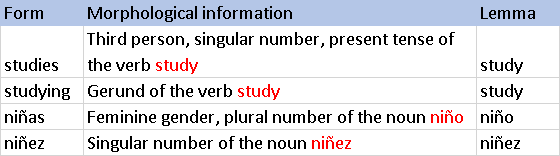

Lemmatization technique is like stemming. The output we will get after lemmatization is called ‘lemma’, which is a root word rather than root stem, the output of stemming. After lemmatization, we will be getting a valid word that means the same thing.

NLTK provides WordNetLemmatizer class which is a thin wrapper around the wordnet corpus. This class uses morphy() function to the WordNet CorpusReader class to find a lemma.

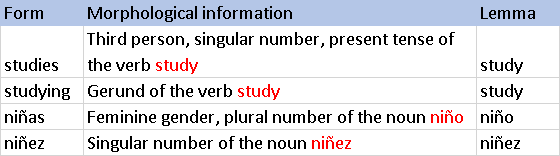

In [ ]:
stemmer = PorterStemmer
def stem_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = stemmer.stem(i.strip(), get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text 

In [ ]:
data['text'] = data['text'].apply(lemmatize_words)

In [ ]:
def join_text(text):
    string = ''
    for i in text:
        string += i.strip() +' '
    return string

In [ ]:
data['text'] = data['text'].apply(join_text)

In [ ]:
data.head()

 Splitting the data into training and testing data

In [ ]:
train_text, test_text, train_category, test_category = train_test_split(data['text'], data['over_18'], random_state=0)

print(train_text.shape)
print(test_text.shape)
print(train_category.shape)
print(test_category.shape)

In [ ]:
# Defining the model
C_V = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,2))

# Transforming the train reviews
C_V_train_reviews = C_V.fit_transform(train_text)

# Transforming the test reviews
C_V_test_reviews = C_V.transform(test_text)

print('Shape of C_V_train:', C_V_train_reviews.shape)
print('Shape of C_V_test:', C_V_test_reviews.shape)

In [ ]:
# Definig the Model
T_V = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
# Transforming the train reviews
T_V_train_reviews = T_V.fit_transform(train_text)

# Transforming the test reviews
T_V_test_reviews = T_V.transform(test_text)

print('Shape of T_V_train:', T_V_train_reviews.shape)
print('Shape of T_V_test:', T_V_test_reviews.shape)

# Using Different Classifier for training and then analysing after the testing

In [ ]:
# Using the Logistic Regression as the First Model
lr = LogisticRegression(penalty='l2', max_iter = 500, C = 1, random_state = 3)

# Fitting the Model 
lr_cv = lr.fit(C_V_train_reviews, train_category)
lr_tfidf = lr.fit(T_V_train_reviews, train_category)

print(lr_cv)
print(lr_tfidf)

In [ ]:
#Predicting the model for bag of words
lr_cv_predict=lr_cv.predict(C_V_test_reviews)
##Predicting the model for tfidf features
lr_tfidf_predict=lr_tfidf.predict(T_V_test_reviews)

In [ ]:
# Calculating the Accuracy Score now

lr_cv_score = accuracy_score(test_category, lr_cv_predict)
lr_tfidf_score=accuracy_score(test_category, lr_tfidf_predict)

print("lr_Cv_score: ", lr_cv_score)
print("lr_tfidf_score :", lr_tfidf_score)

Wow it gave a very high accuracy score 

In [ ]:
# Classification report

lr_cv_report = classification_report(test_category, lr_cv_predict)
lr_tfidf_report = classification_report(test_category, lr_tfidf_predict)

print("Classification Report for Bag of Words \n ", lr_cv_report)
print("Classification Report for TfIdf features \n ", lr_tfidf_report)

In [ ]:
# Plotting the Confusion Matrix
plot_confusion_matrix(lr_cv, C_V_test_reviews, test_category, values_format='')
plot_confusion_matrix(lr_tfidf, T_V_test_reviews, test_category,  values_format='')

In [ ]:
# Using the Multinomial Naive Bayes

# Creating the model
mnb = MultinomialNB()

#fitting the model
mnb_cv = mnb.fit(C_V_train_reviews, train_category)
mnb_tfidf = mnb.fit(T_V_train_reviews, train_category)

# Predicting the model
mnb_cv_predict = mnb_cv.predict(C_V_test_reviews)
mnb_tfidf_predict = mnb_tfidf.predict(T_V_test_reviews)

In [ ]:
# Calculating the Score

mnb_cv_score = accuracy_score(test_category, mnb_cv_predict)
mnb_tfidf_score = accuracy_score(test_category, mnb_tfidf_predict)

# Printing the Accuracy Score

print("mnb_score: ", mnb_cv_score)
print("mnb_tfidf_score: ", mnb_tfidf_score)

In [ ]:
# Classification report

mnb_cv_report = classification_report(test_category, mnb_cv_predict)
mnb_tfidf_report = classification_report(test_category, mnb_tfidf_predict)

print("Classification Report for Bag of Words \n ", mnb_cv_report)
print("Classification Report for TfIdf features \n ", mnb_tfidf_report)

In [ ]:
# Plotting the Confusion Matrix
plot_confusion_matrix(mnb_cv, C_V_test_reviews, test_category, values_format='')
plot_confusion_matrix(mnb_tfidf, T_V_test_reviews, test_category,  values_format='')

Guys if you found this insighful please upvote!